In [40]:
# Basic
import numpy as np
import pandas as pd
import gzip
from math import pi

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
# Viz parameters
sns.set(style="darkgrid")
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8

In [42]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [43]:
# Data cleaning

For this project, I going to use the information from different cities. I used three different cities in Italy: Rome, Florance, Venice and another three in different countries London (UK), Paris (France), Oslo (Norway). 

In order to get this information in a unified way, I'll use a function for loading data. All initial ETL stages to be done in this function.

In [44]:
def load_city(filename):
    '''
    The function takes the dataset from a commpressed file and apply cleaning and feature engineering
    
    INPUT: commpressed filename
    
    OUTPUT: cleaned and modified pandas dataframe
    '''
    
    with gzip.open(filename) as f:
        df = pd.read_csv(f, low_memory=False)
    
    # Drop empty rows 
    df.dropna(axis=0, subset=df.filter(like='review_scores').columns, inplace=True)
    df.dropna(axis=0, subset=['host_listings_count'], inplace=True)
    
    # Transforming amounts to the correct float numbers
    df['price'] = df['price'].str.replace('[^\d\.]','').astype(float)
    df['cleaning_fee'] = df['cleaning_fee'].str.replace('[^\d\.]','').astype(float)
    df['security_deposit'] = df['security_deposit'].str.replace('[^\d\.]','').astype(float)
    df['extra_people'] = df['extra_people'].str.replace('[^\d\.]','').astype(float)
    
    # Create new fiels for further analysis:
    
    # Host category: total number of apartments for rent by host
    df['host_category'] = pd.cut(df['host_listings_count'], [0, 1, 5, 500], labels=["Single", "Few", "Many"])
    
    #City name
    df['dataset'] = filename.split('_')[0].capitalize()
    
    #Security_ratio - a ratio of security deposit to the price per night
    df['security_ratio']=df['security_deposit']/df['price']
    
    # A percentage of time a year, when the apartment is available
    df['available']=df['availability_365']/365
    
    # Category of apartment availablity
    df['availablity_category'] = pd.cut(df['available'], [0, 0.33, 0.66, 1.01], labels=["Busy", "Normal", "Empty"])
    
    return df

In [45]:
# Rome
rome_listing = load_city('data/rome_listings.csv.gz')

# Florence
florence_listing = load_city('data/florence_listings.csv.gz')

# Venice
venice_listing = load_city('data/venice_listings.csv.gz')

# Paris
paris_listing = load_city('data/paris_listings.csv.gz')

# London
london_listing = load_city('data/london_listings.csv.gz')

# Oslo
oslo_listing = load_city('data/oslo_listings.csv.gz')

#Combining all cities in one dataset
listing = pd.concat([rome_listing, florence_listing, venice_listing, paris_listing, london_listing, oslo_listing])

In [46]:
# Data visualization

### Question 1: What is the structure of hosts in different cities?

I'm curious how many of hosts rent out their extra apartments occasionally and for which part it's a really main business.

In [47]:
def count_bar_plot(field, df):
    '''
    The function calculate the percentage of records for defined field in the dataset.
    INPUT: 
    field  - field for analysis
    df - dataset
    
    OUTPUT:
    Seaborn countplot of the field in percentage
    '''
    #descending_order = df[field].value_counts().sort_values(ascending=False).index
    ax = sns.barplot(y=field, x=field, orient="v", data=df, estimator=lambda x: len(x)/len(df)*100)
    ax.set(ylabel="Percent")
    ax.set(xlabel="Host type");

First of all lets look at the overall picture, i.e. all cities together.

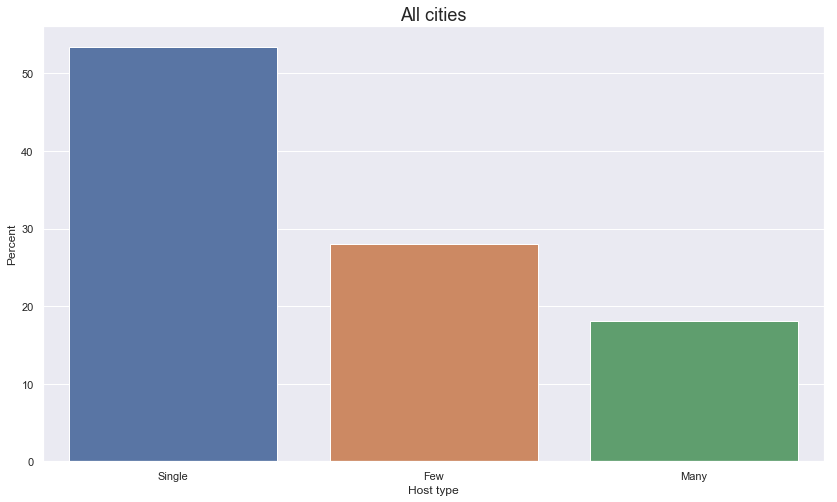

In [48]:
count_bar_plot('host_category', listing)
plt.title('All cities', size=18);

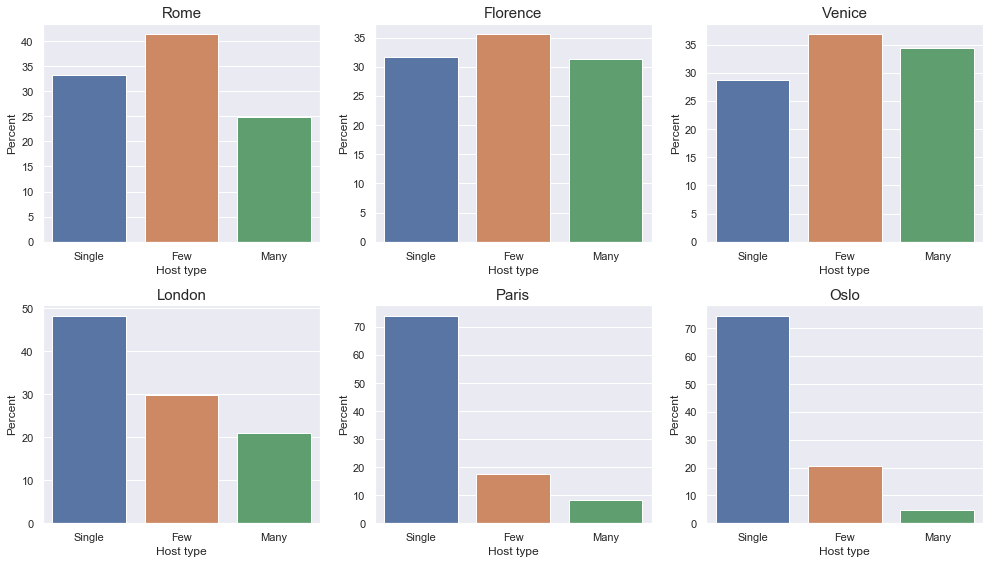

In [49]:
# Split by target groups by city

plt.subplot(2, 3, 1)
count_bar_plot('host_category', rome_listing)
plt.title('Rome', size=15)

plt.subplot(2, 3, 2)
count_bar_plot('host_category', florence_listing)
plt.title('Florence', size=15)

plt.subplot(2, 3, 3)
count_bar_plot('host_category', venice_listing)
plt.title('Venice', size=15)

plt.subplot(2, 3, 4)
count_bar_plot('host_category', london_listing)
plt.title('London', size=15)

plt.subplot(2, 3, 5)
count_bar_plot('host_category', paris_listing)
plt.title('Paris', size=15)

plt.subplot(2, 3, 6)
count_bar_plot('host_category', oslo_listing)
plt.title('Oslo', size=15)

plt.tight_layout()
plt.savefig('plots/host_type.png')

At the plot above we can see that this number in different from city to city and espessialy, it's remarkable how dffierent this share in different countries.
It seem that in Italy, Airbnb used by proffiessionals or some people have a lot of apartments to rent out, while in Norway of France (Paris) it is not a common practice. 

Let's also check how regular they rent their homes out.

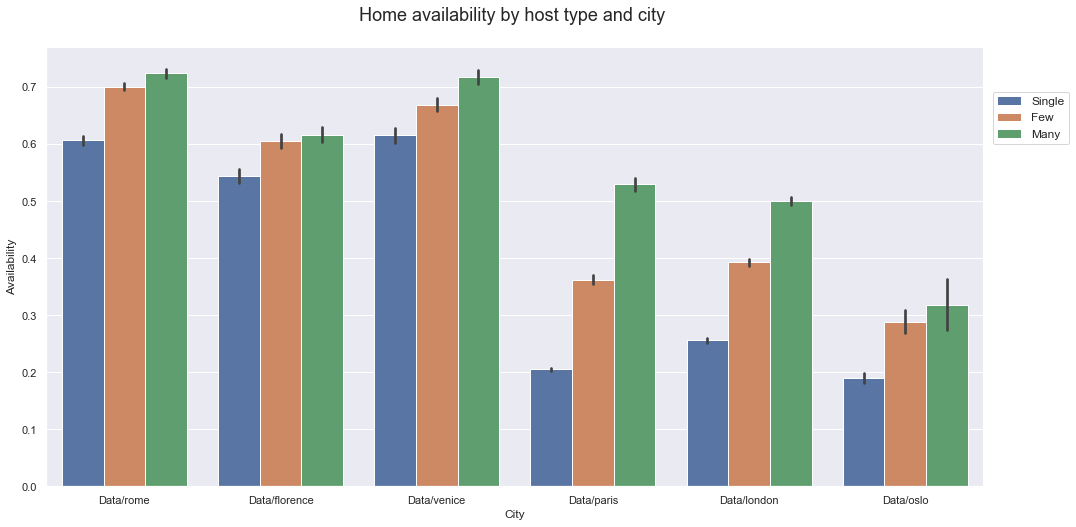

In [50]:
ax = sns.catplot(x="dataset", y="available", hue="host_category", data=listing, kind="bar", height=7, aspect=2, legend=False, estimator=np.mean);
plt.title('Home availability by host type and city \n', size=18)
ax.set(ylabel="Availability")
ax.set(xlabel="City")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2, borderaxespad=0., fontsize=12, facecolor="white")
plt.savefig('plots/listing_availability.png', bbox_inches='tight')

We see that host with a single home than in Paris, London and Olso, rent it out not regularly, while in Italy it's opposite.


### Question 2: Do people really care who is the host?

Let's look how people appraise Airbnb apartments depending on the host category.

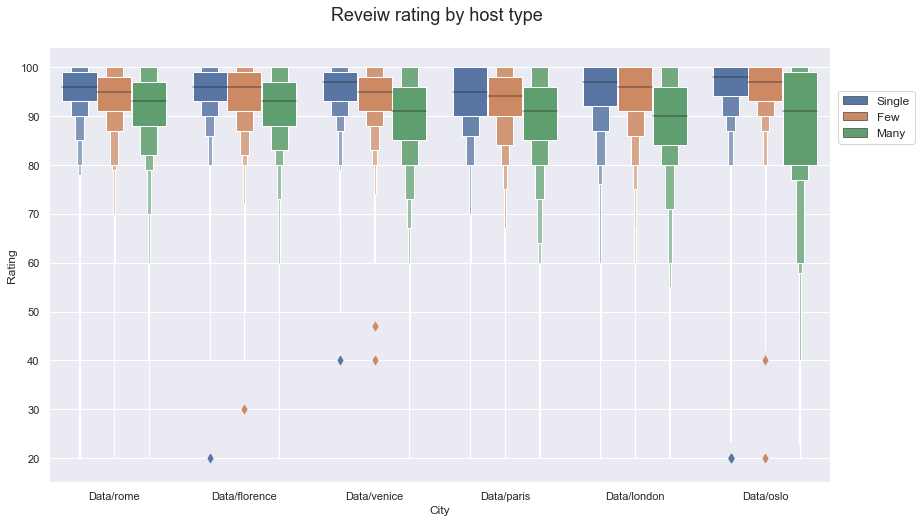

In [51]:
ax = sns.boxenplot(x='dataset', y='review_scores_rating', hue='host_category', data=listing);
plt.title('Reveiw rating by host type \n', size=18)
ax.set(ylabel="Rating")
ax.set(xlabel="City")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2, borderaxespad=0., fontsize=12, facecolor="white")
plt.savefig('plots/host_rating.png')


### Question 3: Are there certain criterias where "professionals" are much different from others?

In [52]:
def radar_plot(df, p, category, legend = False):
    reviews = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
           'review_scores_communication', 'review_scores_location', 'review_scores_value']

    labels = [t.split('_')[2].capitalize() for t in reviews]

    N = len(reviews)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    grouped = df.groupby(category)[reviews].mean().reset_index()
    
    if grouped[category].dtype.name == 'category':
        categories = grouped[category].cat.categories.tolist()
    else:
        categories = grouped[category].unique().tolist()
    
    # Initialise the spider plot
    ax = p
    ax.set_facecolor( '#F5F5F5')

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], []) 


    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)


    for i in range(N):

        angle_rad = i / float(N) * 2 * pi

        if angles[i] == 0:
            ha, distance_ax = "center", 1.05
        elif 0 < angles[i] < pi:
            ha, distance_ax = "left", 1.05
        elif angles[i] == pi:
            ha, distance_ax = "center", 1.05
        else:
            ha, distance_ax = "right", 1.05

        ax.text(angles[i], 9 + distance_ax, labels[i], size=13, horizontalalignment=ha, verticalalignment="center")



    # Draw ylabels
    ax.set_rlabel_position(90)
    plt.yticks(range(8,11,1), color="grey", size=12, rotation=45)
    plt.ylim(8,10)


    for i in grouped[category].index:
        values=grouped.iloc[i, 1:].values.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=3, linestyle='solid', label=grouped.loc[i][category])
        ax.fill(angles, values, 'b', alpha=0.05)


    # Add legend
    if legend == True:
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    return ax

    

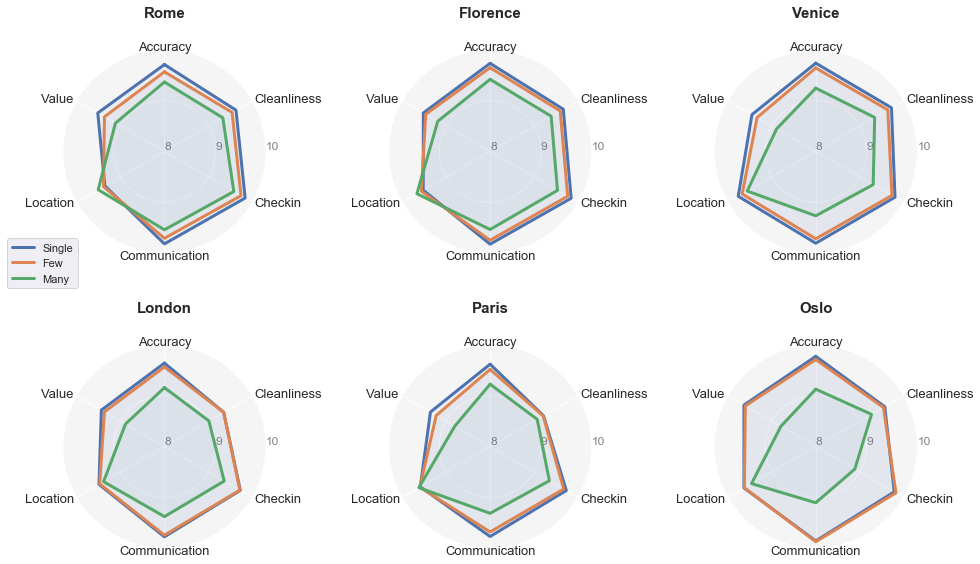

In [53]:
p1 = plt.subplot(2, 3, 1, polar=True)
radar_plot(rome_listing, p1, 'host_category', True)
plt.title('Rome' + "\n", fontweight='bold', size=15)

p2 = plt.subplot(2, 3, 2, polar=True)
radar_plot(florence_listing, p2, 'host_category')
plt.title('Florence'+ "\n", fontweight='bold', size=15)

p3 = plt.subplot(2, 3, 3, polar=True)
radar_plot(venice_listing, p3, 'host_category')
plt.title('Venice'+ "\n", fontweight='bold', size=15)

p4 = plt.subplot(2, 3, 4, polar=True)
radar_plot(london_listing, p4, 'host_category')
plt.title('London'+ "\n", fontweight='bold', size=15)

p5 = plt.subplot(2, 3, 5, polar=True)
radar_plot(paris_listing, p5, 'host_category')
plt.title('Paris'+ "\n", fontweight='bold', size=15)

p6 = plt.subplot(2, 3, 6, polar=True)
radar_plot(oslo_listing, p6, 'host_category')
plt.title('Oslo'+ "\n", fontweight='bold', size=15)

plt.tight_layout()

plt.savefig('plots/host_criterias.png')

There is only one score of host with many apartments, which is closer to other host - Location.

#### Qustion 4: Are reviews correlating with the host's type?

In order to compare the reveiws for homes in different cities, we have to adjust number of reviews to the home avialibility.

In [54]:
# Number of reviews adjusted to the listing availability in 30 days
listing['reviews_adjusted']=np.where(listing['availability_30']==0,0,listing['reviews_per_month']*(30/listing['availability_30']))

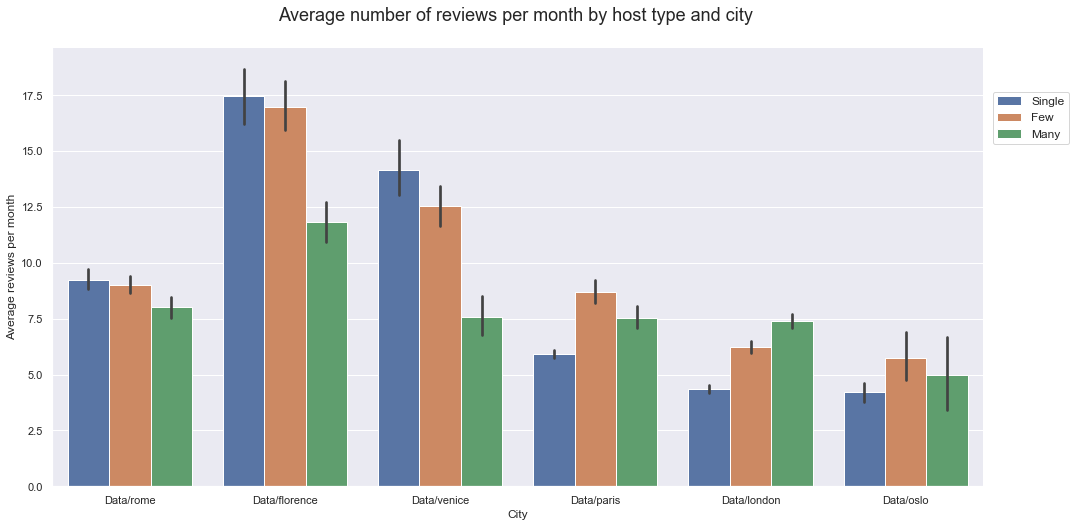

In [55]:
ax = sns.catplot(x="dataset", y="reviews_adjusted", hue="host_category", data=listing, kind="bar", height=7, aspect=2, legend=False, estimator=np.mean);
plt.title('Average number of reviews per month by host type and city \n', size=18)
ax.set(ylabel="Average reviews per month")
ax.set(xlabel="City")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2, borderaxespad=0., fontsize=12, facecolor="white")
plt.savefig('plots/avg_reviews.png', bbox_inches='tight')
plt.show();